# Credible intervals for scCODA

We want to place credible intervals on the effects in scCODA. Since we have spike-and-slab priors, this is not straightforward.
The relevant part of the model is as follows:

$
\begin{align*}
\beta_{d, \hat{k}} &= 0 & \forall d \in [D]\\
\beta_{d, k} &= \tau_{d, k} \tilde{\beta}_{d, k} \quad & \forall d \in [D], k \in \{[K] \smallsetminus \hat{k}\} \\
\tau_{d, k} &= \frac{\exp(t_{d, k})}{1+ \exp(t_{d, k})} \quad & \forall d \in [D], k \in \{[K] \smallsetminus \hat{k}\} \\
\frac{t_{d, k}}{50} &\sim N(0, 1) \quad & \forall d \in [D], k \in \{[K] \smallsetminus \hat{k}\} \\
\end{align*}
$

There are two methods for credible intervals on $\beta$ that we want to try out:

**1. Interval of proposed effect**

We simply take the interval of the effect before applying the spike-and-slab prior, $\tilde{\beta}$

$HDI(\beta) \approx HDI(\tilde{\beta})$

**2. Interval over nonzero effects**

For effects that are considered credibly different from 0, we build the confidence interval over all "slab" MCMC samples:

$HDI(\beta) := HDI(\beta_m | \tau_m > 0)$

In [1]:
# Setup

# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import pickle as pkl
import os
import anndata as ad
import arviz as az

from sccoda.util import comp_ana as mod
from sccoda.util import result_classes as res

pd.set_option('display.max_columns', None)

## Get some model and result: Smillie LP healthy vs. non-inflamed


In [2]:
importlib.reload(mod)
importlib.reload(res)

data_smillie_lp = ad.read_h5ad("../../sccoda_benchmark_data/smillie_lp.h5ad")
lp_h_n = data_smillie_lp[data_smillie_lp.obs["Health"].isin(["Healthy", "Non-inflamed"])]

model2_lphn = mod.CompositionalAnalysis(lp_h_n, formula="Health", reference_cell_type="CD8+ IELs")
lphn_results = model2_lphn.sample_hmc()
lphn_results.summary_extended()



/Users/johannes.ostner/opt/anaconda3/envs/scCODA_2/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.X` of view, copying.
/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/result_classes.py:249: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/Users/johannes.ostner/opt/anaconda3/envs/scCODA_2/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (64.827 sec)
Acceptance rate: 58.1%
Compositional Analysis summary (extended):

Data: 48 samples, 37 cell types
Reference index: 6
Formula: Health
Spike-and-slab threshold: 0.788

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 64.827 sec. Acceptance rate: 58.1%

Intercepts:
                          Final Parameter  HDI 3%  HDI 97%     SD  \
Cell Type                                                           
CD4+ Activated Fos-hi               1.217   0.984    1.460  0.130   
CD4+ Activated Fos-lo               1.268   1.028    1.518  0.135   
CD4+ Memory                         0.816   0.542    1.101  0.158   
CD4+ PD1+                          -1.581  -2.040   -1.110  0.250   
CD69+ Mast                          0.220  -0.042    0.458  0.132   
CD69- Mast                         -3.584  -4.531   -2.641  0.515   
CD8+ IELs                          -0.670  -0.936   -0.428  0.136   

## Compute three different interval borders and widths

Methods:

- "normal": interval on beta - zero-inflated
- "raw": Method 1 from above
- "sel": Method 2 from above

In [3]:
# Just the interval on beta
summary_beta = az.summary(lphn_results, kind="stats", var_names=["beta"])
summary_b_raw = az.summary(lphn_results, kind="stats", var_names=["b_raw"])

cell_types = lphn_results.posterior.coords["cell_type"].values
cell_types_nb = lphn_results.posterior.coords["cell_type_nb"].values
covariates = lphn_results.posterior.coords["covariate"].values

summary_beta.index = pd.MultiIndex.from_product([covariates, cell_types],
                                             names=["Covariate", "Cell Type"])

# Interval on b_raw
ref_index = lphn_results.model_specs["reference"]

def insert_row(idx, df, df_insert):
    return df.iloc[:idx, ].append(df_insert).append(df.iloc[idx:, ]).reset_index(drop = True)

summary_b_raw = insert_row(ref_index, summary_b_raw, pd.DataFrame.from_dict(data={"mean": [0], "sd": [0], "hdi_3%": [0], "hdi_97%": [0]}))
summary_b_raw.index = pd.MultiIndex.from_product([covariates, cell_types],
                                             names=["Covariate", "Cell Type"])

# interval on nonzero beta
ind_post = lphn_results.posterior["ind"]

post_sel = ind_post.where(ind_post >= 1e-3)

b_raw_sel = lphn_results.posterior["b_raw"] * ind_post.where(ind_post >= 1e-3)

res = az.convert_to_inference_data(b_raw_sel)

summary_sel = az.summary(res, kind="stats", var_names=["x"], skipna=True)

summary_sel = insert_row(ref_index, summary_sel, pd.DataFrame.from_dict(data={"mean": [0], "sd": [0], "hdi_3%": [0], "hdi_97%": [0]}))
summary_sel.index = pd.MultiIndex.from_product([covariates, cell_types],
                                             names=["Covariate", "Cell Type"])

In [4]:
total_summ = pd.concat([summary_beta, summary_b_raw, summary_sel], keys=["normal", "raw", "sel"], names=["method"])

total_summ["width"] = total_summ["hdi_97%"] - total_summ["hdi_3%"]

print(total_summ)

                                                      mean     sd  hdi_3%  \
method Covariate              Cell Type                                     
normal Health[T.Non-inflamed] CD4+ Activated Fos-hi -0.720  0.204  -1.151   
                              CD4+ Activated Fos-lo -1.086  0.205  -1.441   
                              CD4+ Memory           -0.242  0.244  -0.680   
                              CD4+ PD1+             -1.029  0.403  -1.820   
                              CD69+ Mast            -0.059  0.145  -0.441   
...                                                    ...    ...     ...   
sel    Health[T.Non-inflamed] WNT2B+ Fos-hi         -0.623  0.232  -1.067   
                              WNT2B+ Fos-lo 1       -0.669  0.207  -1.070   
                              WNT2B+ Fos-lo 2       -0.325  0.242  -0.781   
                              WNT5B+ 1              -0.755  0.237  -1.216   
                              WNT5B+ 2              -0.558  0.233  -1.010   

## Analysis

Width of intervals:

For non-credible effects, the intervals for method 1 are much larger!

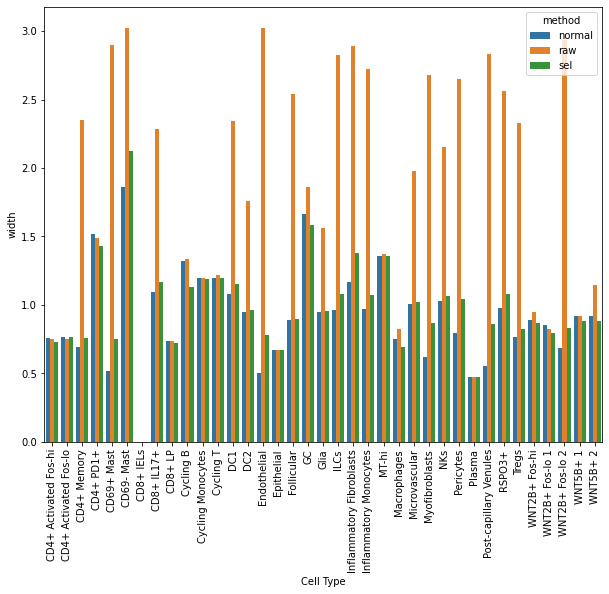

In [5]:
total_summ2 = total_summ.reset_index()

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(data=total_summ2.reset_index(), x="Cell Type", y="width", hue="method")
plt.xticks(rotation=90)
legend_labels, _= ax.get_legend_handles_labels()
plt.show()

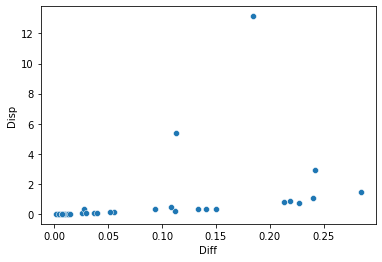

     method               Covariate  Cell Type   mean     sd  hdi_3%  hdi_97%  \
27   normal  Health[T.Non-inflamed]  Pericytes  0.133  0.247  -0.034    0.761   
64      raw  Health[T.Non-inflamed]  Pericytes  0.219  0.671  -1.053    1.594   
101     sel  Health[T.Non-inflamed]  Pericytes  0.327  0.294  -0.103    0.937   

     width  
27   0.795  
64   2.647  
101  1.040  


In [6]:
mean_diff_df = pd.DataFrame({
    "Cell Type": total_summ2.loc[total_summ2["method"] == "raw", "Cell Type"],
    "Diff": np.abs(np.array(total_summ2.loc[total_summ2["method"] == "raw", "mean"]) - np.array(total_summ2.loc[total_summ2["method"] == "sel", "mean"])),
    "Inclusion probability": lphn_results.effect_df["Inclusion probability"].values
})

mean_diff_df["Disp"] = mean_diff_df["Diff"]/np.abs(np.array(total_summ2.loc[total_summ2["method"] == "raw", "mean"]))

sns.scatterplot(data=mean_diff_df, x="Diff", y="Disp")
plt.show()

print(total_summ2[total_summ2["Cell Type"] =="Pericytes"])

Correlation with inclusion probability for method 1 is very clear: The higher the inc. prob, the smaller the interval.

In [7]:
summ_raw = total_summ.loc[total_summ.index.get_level_values(0) =="raw"].copy()
print(summ_raw)

summ_raw.loc[:, "Inclusion probability"] = lphn_results.effect_df["Inclusion probability"].values

print(summ_raw)


                                                         mean     sd  hdi_3%  \
method Covariate              Cell Type                                        
raw    Health[T.Non-inflamed] CD4+ Activated Fos-hi    -0.730  0.215  -1.151   
                              CD4+ Activated Fos-lo    -1.092  0.203  -1.458   
                              CD4+ Memory              -0.269  0.565  -1.151   
                              CD4+ PD1+                -1.039  0.411  -1.816   
                              CD69+ Mast                0.014  0.765  -1.246   
                              CD69- Mast               -0.311  0.792  -1.772   
                              CD8+ IELs                 0.000  0.000   0.000   
                              CD8+ IL17+               -0.411  0.579  -1.366   
                              CD8+ LP                  -0.752  0.217  -1.150   
                              Cycling B                -0.814  0.398  -1.577   
                              Cycling Mo

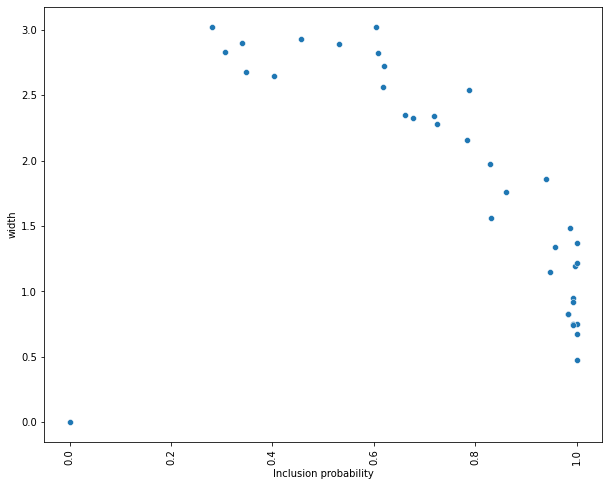

In [8]:
plt.subplots(figsize=(10,8))
sns.scatterplot(data=summ_raw.reset_index(), x="Inclusion probability", y="width")
plt.xticks(rotation=90)
plt.show()


In [41]:
print(total_summ2.columns)

Index(['method', 'Covariate', 'Cell Type', 'mean', 'sd', 'hdi_3%', 'hdi_97%',
       'width'],
      dtype='object')


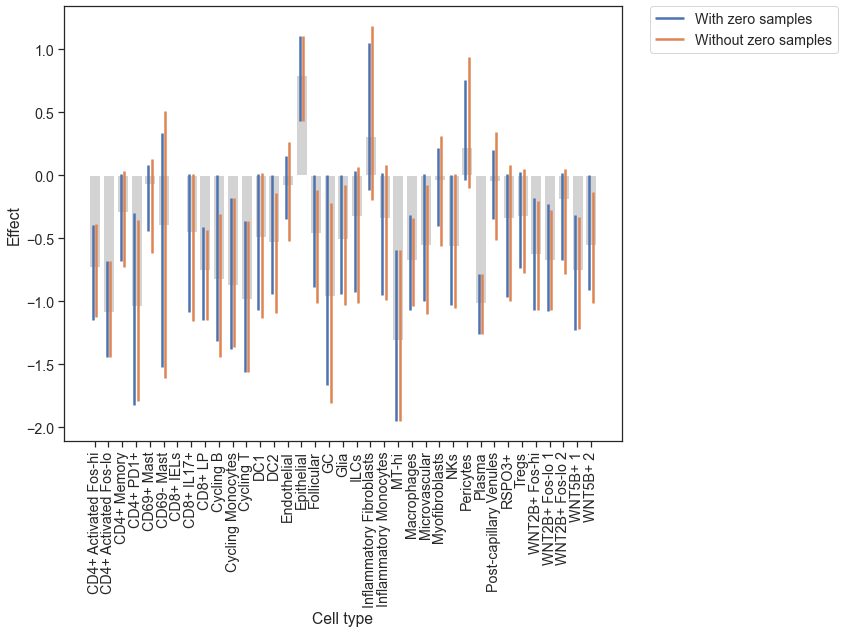

In [50]:
sns.set(style="ticks", font_scale=1.3)

fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(data=total_summ2,
            x="Cell Type",
            y="mean",
            color="lightgrey",
            ci=None)

plt.vlines(
    x=np.arange(0,37)-0.125,
    ymin=total_summ2.loc[total_summ2["method"]=="normal", "hdi_3%"],
    ymax=total_summ2.loc[total_summ2["method"]=="normal", "hdi_97%"],
    color=sns.color_palette()[0],
    label="With zero samples",
    lw=2.5
)

plt.vlines(
    x=np.arange(0,37)+0.125,
    ymin=total_summ2.loc[total_summ2["method"]=="sel", "hdi_3%"],
    ymax=total_summ2.loc[total_summ2["method"]=="sel", "hdi_97%"],
    color=sns.color_palette()[1],
    label="Without zero samples",
    lw=2.5
)
plt.xticks(rotation=90, labels=lp_h_n.var.index, ticks=np.arange(len(lp_h_n.var.index)))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Cell type")
plt.ylabel("Effect")

legend_labels, _= ax.get_legend_handles_labels()

plot_path = "../../sccoda_benchmark_data/paper_plots_rv1/"
plt.savefig(plot_path + "/ci_bars_smillie_lp_h_n.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "/ci_bars_smillie_lp_h_n.png", format="png", bbox_inches="tight")

plt.show()

In [51]:

print(total_summ2.groupby("method").agg({
    "width": "mean"
}))

           width
method          
normal  0.920703
raw     1.807108
sel     0.974405


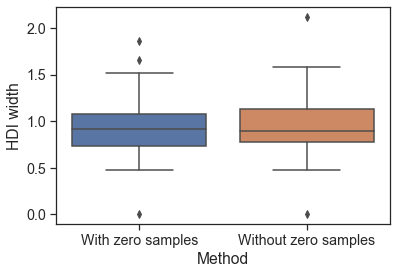

In [52]:
sns.boxplot(
    data=total_summ2.loc[total_summ2["method"]!="raw",:],
    x="method",
    y="width"
)
plt.xlabel("Method")
plt.xticks(ticks=[0,1], labels=["With zero samples", "Without zero samples"])
plt.ylabel("HDI width")

plt.savefig(plot_path + "/ci_width_boxes_smillie_lp_h_n.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "/ci_width_boxes_smillie_lp_h_n.png", format="png", bbox_inches="tight")


plt.show()